In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 8)

from get_draws.api import get_draws
from db_queries import get_ids

#from scipy import stats
from scipy.interpolate import griddata, RectBivariateSpline
# import re

# Add path "vivarium_research_lsff/nanosim_models" to sys.path so imports will work from parent folder
import sys, os.path
# Note: Assuming pwd = vivarium_research_lsff/nanosim_models/notebooks
sys.path.append(os.path.abspath(".."))

# import lbwsg # in `vivarium_research_lsff/nanosim_models`
import lbwsg_plots # in `vivarium_research_lsff/nanosim_models`

!date
!whoami
!pwd

Tue Oct  5 10:13:34 PDT 2021
ndbs
/ihme/homes/ndbs/vivarium_research_lsff/nanosim_models/notebooks


In [2]:
%load_ext autoreload
%autoreload 2

# Functions to read in and format LBWSG input data

In [3]:
def cats_to_ordered_categorical(risk_categories: pd.Series) -> pd.Categorical:
    """Converts a Series of risk categories stored as strings of the form 'cat###' to a Pandas Categorical,
    with the natural sort order (https://en.wikipedia.org/wiki/Natural_sort_order).
    The ordered Categorical is useful for automatically aligning data by risk category.
    """
    ordered_categories = sorted(risk_categories.unique(), key=lambda s: int(s.strip('cat')))
    return pd.Categorical(risk_categories, categories=ordered_categories, ordered=True)

def string_to_interval(interval_strings: pd.Series) -> pd.Series:
    """Converts a Series of strings of the form '(a, b)', '[a, b)', '(a, b]', or '[a, b]' into
    a Series of pandas Interval objects. The a's and b's must be nonnegative integers.
    """
    interval_pattern = r'(?P<left_delimiter>[\(\[])(?P<left>\d+), (?P<right>\d+)(?P<right_delimiter>[\)\]])'
    df = interval_strings.str.extract(interval_pattern)
    df['left_closed'] = (df['left_delimiter'] == '[').astype(int) # 1 or 0
    df['right_closed'] = (df['right_delimiter'] == ']').astype(int) # 1 or 0
    df['closed'] = (df['left_closed']+2*df['right_closed']).map({0:'neither', 1:'left', 2:'right', 3:'both'})
    intervals = np.vectorize(pd.Interval)(df['left'].astype(int), df['right'].astype(int), df['closed'])
    return pd.Series(intervals, index=interval_strings.index, name=interval_strings.name)

def read_cat_df(filename: str) -> pd.DataFrame:
    """Reads in the LBWSG category data .csv as a DataFrame, and converts the category column into a
    pandas ordered Categorical and the GA and BW interval columns into Series of pandas Interval objects.
    """
    cat_df = pd.read_csv(filename)
    cat_df['lbwsg_category'] = cats_to_ordered_categorical(cat_df['lbwsg_category'])
    cat_df['ga_interval'] = string_to_interval(cat_df['ga_interval'])
    cat_df['bw_interval'] = string_to_interval(cat_df['bw_interval'])
    return cat_df

def get_rr_data(source='get_draws', rr_key=None, draw=None, preprocess=False) -> pd.DataFrame:
    """Reads GBD's LBWSG relative risk data from an HDF store or DataFrame or pulls it using get_draws,
    and, if preprocess is True, reformats the RRs into a DataFrame containing a single RR value for
    each age group, sex, and category.
    The DataFrame is indexed by age_group_id and sex_id, and the columns are the LBWSG categories.
    The single RR value will be from the specified draw, or the mean of all draws if draw=='mean'.
    If preprocess is False, the raw GBD data will be returned instead.
    """
    if isinstance(source, pd.DataFrame):
        # Assume source is raw rr data from GBD
        rr = source
    elif source == 'get_draws':
        # Call get draws
        LBWSG_REI_ID = 339
        DIARRHEAL_DISEASES_CAUSE_ID = 302 # Can be any most-detailed cause affected by LBWSG
        GLOBAL_LOCATION_ID = 1 # Passing any location will return RRs for Global
        GBD_2019_ROUND_ID = 6
        rr = get_draws(
            gbd_id_type=('rei_id','cause_id'),
            gbd_id=(LBWSG_REI_ID, DIARRHEAL_DISEASES_CAUSE_ID),
            source='rr',
            location_id=GLOBAL_LOCATION_ID,
            year_id=2019,
            gbd_round_id=GBD_2019_ROUND_ID,
            status='best',
            decomp_step='step4',
        )
    else:
        # Assume source is a string representing a filepath, a Path object, or an HDFStore object
        # Will raise an error if rr_key is None and source hdf contains more than one pandas object
        rr = pd.read_hdf(source, rr_key)
    
    if preprocess:
        draw_cols = rr.filter(like='draw').columns
        rr = rr.assign(lbwsg_category=lambda df: cats_to_ordered_categorical(df['parameter'])) \
               .set_index(['age_group_id', 'sex_id', 'lbwsg_category'])[draw_cols]

        if draw is None:
            raise ValueError("draw must be specified if preprocess is True")
        elif draw == 'mean':
            rr = rr.mean(axis=1)#.rename('lbwsg_relative_risk_mean')
        else:
            rr = rr[f'draw_{draw}']#.rename(f'lbwsg_relative_risk_draw_{draw}')
        # After unstacking, each row is one age group and sex, columns are categories
        # Categories will be sorted in natural sort order because they're stored in an ordered Categorical
        rr = rr.unstack('lbwsg_category')
    return rr

# Step 0: Load and display LBWSG category data and RR data

In [4]:
# Step 0: Get LBWSG relative risk data and category data
lbwsg_hdf = '/share/scratch/users/ndbs/vivarium_lsff/gbd_data/lbwsg_data.hdf'
hdf_rr_key = '/gbd_2019/relative_risk/diarrheal_diseases'
# raw_rr is raw GBD data returned by get_draws
raw_rr = get_rr_data(lbwsg_hdf, hdf_rr_key, preprocess=False)

# Pick a draw
draw = 29
# rr is a Series indexed by age_group_id, sex_id, lbwsg_category
rr = get_rr_data(raw_rr, hdf_rr_key, draw=draw, preprocess=True)

cat_df_filename = 'lbwsg_category_data.csv'
# Reads the csv and converts LBWSG categories to ordered pandas Categorical
# and string representations of intervals to pandas Interval objects.
cat_df = read_cat_df(cat_df_filename)

In [5]:
raw_rr

,rei_id,modelable_entity_id,location_id,year_id,age_group_id,sex_id,cause_id,mortality,morbidity,metric_id,...,draw_990,draw_991,draw_992,draw_993,draw_994,draw_995,draw_996,draw_997,draw_998,draw_999
0,339,10810,1,2019,2,2,302,1,0,3,...,906.355930,1171.264520,1010.027950,986.421764,494.776193,537.871368,880.219326,796.623230,903.979011,943.601981
1,339,10810,1,2019,2,2,302,1,0,3,...,683.137849,824.643972,542.771578,633.041692,647.404629,478.471757,565.002324,703.592110,683.569330,769.060023
2,339,10810,1,2019,2,2,302,1,0,3,...,496.548577,501.217895,612.924435,507.091453,423.021838,367.708896,404.109679,466.427140,475.480542,494.876186
3,339,10810,1,2019,2,2,302,1,0,3,...,312.971545,273.942950,365.489360,297.644030,271.017682,218.688389,233.602302,236.271802,251.805871,241.935671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228,339,10810,1,2019,3,1,302,1,0,3,...,2.620089,2.597227,2.735096,2.569520,2.851738,2.965840,2.555629,2.802927,3.147952,2.923688
229,339,10810,1,2019,3,1,302,1,0,3,...,1.000000,1.211495,1.334712,1.226655,1.332490,1.286623,1.213633,1.119466,1.433590,1.298277
230,339,10810,1,2019,3,1,302,1,0,3,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
231,339,10810,1,2019,3,1,302,1,0,3,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
get_ids('rei').query("rei_id == 339")

,rei_id,rei_name,rei
255,339,Low birth weight and short gestation,nutrition_lbw_preterm


In [7]:
get_ids('cause').query("cause_id == 302")

,cause_id,cause_name,acause,cause_description
8,302,Diarrheal diseases,diarrhea,None


In [8]:
print(f"Relative risks for {draw=}")
rr

Relative risks for draw=29


lbwsg_category             cat2        cat8       cat10       cat11  \
age_group_id sex_id                                                   
2            1       885.522029  617.193980  523.359754  299.313612   
             2       715.540891  614.425995  509.065377  259.850437   
3            1       416.587487  358.931149  373.098755  296.439829   
             2       595.946191  436.301669  377.115534  322.955344   

lbwsg_category            cat14       cat15       cat17      cat19      cat20  \
age_group_id sex_id                                                             
2            1       118.287898  163.248490  192.188728  98.771075  88.955459   
             2       114.083816  155.280624  121.993314  71.986421  53.626066   
3            1       115.093166  207.925531  144.592475  43.425021  45.697588   
             2       131.874676  179.727395  136.802845  41.404474  41.218441   

lbwsg_category            cat21  ...      cat88      cat89      cat90  \
age_group_id sex_id              ...                                    
2            1        80.286856  ...  29.137853  27.685091  17.383389   
             2        73.059776  ...  26.765806  27.209505  20.286991   
3            1       102.518274  ...  13.100302   6.373274   5.899353   
             2        91.216158  ...  12.955672  10.418975   5.036925   

lbwsg_category           cat95      cat96     cat106      cat116     cat117  \
age_group_id sex_id                                                           
2            1       25.158808  17.170383  92.109797   82.055098  35.188631   
             2       20.461962  20.509504  51.962994  107.459306  34.300217   
3            1        5.497742   3.953201  43.986534   54.688186  21.011601   
             2        7.420304   7.094801  50.950603   64.315075  23.778588   

lbwsg_category          cat123      cat124  
age_group_id sex_id                         
2            1       46.066011  131.354580  
             2       35.933446   72.432557  
3            1       22.085155   47.759661  
             2       27.641487   57.889557  

[4 rows x 58 columns]

In [9]:
cat_df

,lbwsg_category,modelable_entity_id,modelable_entity_name,ga_start,ga_end,bw_start,bw_end,ga_interval,ga_width,ga_midpoint,bw_interval,bw_width,bw_midpoint
0,cat2,10755,"Birth prevalence - [0, 24) wks, [0, 500) g",0,24,0,500,"[0, 24)",24,12.0,"[0, 500)",500,250.0
1,cat8,10761,"Birth prevalence - [0, 24) wks, [500, 1000) g",0,24,500,1000,"[0, 24)",24,12.0,"[500, 1000)",500,750.0
2,cat10,10763,"Birth prevalence - [24, 26) wks, [500, 1000) g",24,26,500,1000,"[24, 26)",2,25.0,"[500, 1000)",500,750.0
3,cat11,10764,"Birth prevalence - [26, 28) wks, [500, 1000) g",26,28,500,1000,"[26, 28)",2,27.0,"[500, 1000)",500,750.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
54,cat116,20227,"Birth prevalence - [38, 40) wks, [1000, 1500) g",38,40,1000,1500,"[38, 40)",2,39.0,"[1000, 1500)",500,1250.0
55,cat117,20228,"Birth prevalence - [38, 40) wks, [1500, 2000) g",38,40,1500,2000,"[38, 40)",2,39.0,"[1500, 2000)",500,1750.0
56,cat123,20232,"Birth prevalence - [40, 42) wks, [1500, 2000) g",40,42,1500,2000,"[40, 42)",2,41.0,"[1500, 2000)",500,1750.0
57,cat124,20224,"Birth prevalence - [37, 38) wks, [1000, 1500) g",37,38,1000,1500,"[37, 38)",1,37.5,"[1000, 1500)",500,1250.0


In [10]:
cat_df.dtypes # Check that conversions to Categorical and Interval worked

lbwsg_category                        category
modelable_entity_id                      int64
modelable_entity_name                   object
ga_start                                 int64
                                 ...          
ga_midpoint                            float64
bw_interval              interval[int64, left]
bw_width                                 int64
bw_midpoint                            float64
Length: 13, dtype: object

In [11]:
rr.columns # View categories in natural sort order

CategoricalIndex(['cat2', 'cat8', 'cat10', 'cat11', 'cat14', 'cat15', 'cat17',
                  'cat19', 'cat20', 'cat21', 'cat22', 'cat23', 'cat24',
                  'cat25', 'cat26', 'cat27', 'cat28', 'cat29', 'cat30',
                  'cat31', 'cat32', 'cat33', 'cat34', 'cat35', 'cat36',
                  'cat37', 'cat38', 'cat39', 'cat40', 'cat41', 'cat42',
                  'cat43', 'cat44', 'cat45', 'cat46', 'cat47', 'cat48',
                  'cat49', 'cat50', 'cat51', 'cat52', 'cat53', 'cat54',
                  'cat55', 'cat56', 'cat80', 'cat81', 'cat82', 'cat88',
                  'cat89', 'cat90', 'cat95', 'cat96', 'cat106', 'cat116',
                  'cat117', 'cat123', 'cat124'],
                 categories=['cat2', 'cat8', 'cat10', 'cat11', 'cat14', 'cat15', 'cat17', 'cat19', ...], ordered=True, dtype='category', name='lbwsg_category')

# Function to look up which (GA,BW) coordinates are in a TMREL category

In [12]:
def get_tmrel_mask(
    ga_coordinates: np.ndarray, bw_coordinates: np.ndarray, cat_df: pd.DataFrame, grid: bool
) -> np.ndarray:
    """Returns a boolean mask indicating whether each pair of (ga,bw) coordinates is in a TMREL category.

    The calling convention using the `grid` parameter is the same as for the scipy.interpolate classes:
    
        If grid is True, the 1d arrays ga_coordinates and bw_coordinates are interpreted as lists of 
        x-axis and y-axis coordinates defining a 2d grid, i.e. the coordinates to look up are the pairs
        in the Carteian product ga_coordinates x bw_coordinates, and the returned mask will have shape
        (len(ga_coordinates), len(bw_coordinates)).

        If grid is False, the 1d arrays ga_coordinates and bw_coordinates must have the same length and are
        interpreted as listing pairs of coordinates, i.e. the coordinates to look up are the pairs in
        zip(ga_coordinates, bw_coordinates), and the returned mask will have shape (n,), where n is the
        common length of ga_coordinates and bw_coordinates.
    """
    TMREL_CATEGORIES = ('cat53', 'cat54', 'cat55', 'cat56')

    # Set index of cat_df to a MultiIndex of pandas IntervalIndex objects to enable
    # looking up LBWSG categories by (GA,BW) coordinates via DataFrame.reindex
    cat_data_by_interval = cat_df.set_index(['ga_interval', 'bw_interval'])

    # Create a MultiIndex of (GA,BW) coordinates to look up, one row for each interpolation point
    if grid:
        # Interpret GA and BW coordinates as the x and y coordinates of a grid (take Cartesian product)
        ga_bw_coordinates = pd.MultiIndex.from_product(
            (ga_coordinates, bw_coordinates), names=('ga_coordinate', 'bw_coordinate')
        )
    else:
        # Interpret GA and BW coordinates as a sequence of points (zip the coordinate arrays)
        ga_bw_coordinates = pd.MultiIndex.from_arrays(
            (ga_coordinates, bw_coordinates), names=('ga_coordinate', 'bw_coordinate')
        )

    # Create a DataFrame to store category data for each (GA,BW) coordinate in the grid
    ga_bw_cat_data = pd.DataFrame(index=ga_bw_coordinates)

    # Look up category for each (GA,BW) coordinate and check whether it's a TMREL category
    ga_bw_cat_data['lbwsg_category'] = cat_data_by_interval['lbwsg_category'].reindex(ga_bw_coordinates)
    ga_bw_cat_data['in_tmrel'] = ga_bw_cat_data['lbwsg_category'].isin(TMREL_CATEGORIES)

    print("Number of interpolation points in TMREL =", ga_bw_cat_data['in_tmrel'].sum())

    # Pull the TMREL mask out of the DataFrame and convert to a numpy array, reshaping into a 2D grid if necessary
    tmrel_mask = ga_bw_cat_data['in_tmrel'].to_numpy()
    if grid:
        # Make a 2D mask the same shape as the grid,
        tmrel_mask = tmrel_mask.reshape((len(ga_coordinates), len(bw_coordinates)))
    return tmrel_mask

# Test the TMREL mask function on cat_df
tmrel_cats = get_tmrel_mask(cat_df['ga_midpoint'], cat_df['bw_midpoint'], cat_df, grid=False)
cat_df.loc[tmrel_cats]

Number of interpolation points in TMREL = 4


,lbwsg_category,modelable_entity_id,modelable_entity_name,ga_start,ga_end,bw_start,bw_end,ga_interval,ga_width,ga_midpoint,bw_interval,bw_width,bw_midpoint
41,cat53,10806,"Birth prevalence - [38, 40) wks, [4000, 4500) g",38,40,4000,4500,"[38, 40)",2,39.0,"[4000, 4500)",500,4250.0
42,cat54,10807,"Birth prevalence - [38, 40) wks, [3500, 4000) g",38,40,3500,4000,"[38, 40)",2,39.0,"[3500, 4000)",500,3750.0
43,cat55,10808,"Birth prevalence - [40, 42) wks, [3500, 4000) g",40,42,3500,4000,"[40, 42)",2,41.0,"[3500, 4000)",500,3750.0
44,cat56,10809,"Birth prevalence - [40, 42) wks, [4000, 4500) g",40,42,4000,4500,"[40, 42)",2,41.0,"[4000, 4500)",500,4250.0


# Do RR interpolation steps 1-7 for a random test population

In [13]:
%%time
# Steps 1 - 5a: Create an interpolator object for each (age_group_id, sex_id) to interpolate log(RR)

def make_lbwsg_log_rr_interpolator(rr: pd.DataFrame, cat_df: pd.DataFrame) -> pd.Series:
    """Returns a length-4 Series of RectBivariateSpline interpolators for the logarithms of
    the given set of LBWSG RRs, indexed by age_group_id and sex_id.
    """
    # Step 1: Get coordinates of LBWSG category midpoints, indexed by category
    interval_data_by_cat = cat_df.set_index('lbwsg_category') # Category index will be in natural sort order
    ga_midpoints = interval_data_by_cat['ga_midpoint']
    bw_midpoints = interval_data_by_cat['bw_midpoint']

    # Step 2: Take logs of LBWSG relative risks
    # Each row of RR is one age group and sex, columns are LBWSG categories
    # Categories (columns) are in natural sort order because they're stored in an ordered Categorical
    log_rr = np.log(rr)

    # Make sure z values are correctly aligned with x and y values (should hold because categories are ordered)
    assert ga_midpoints.index.equals(log_rr.columns) and bw_midpoints.index.equals(log_rr.columns),\
        "Interpolation (ga,bw)-points and rr-values are misaligned!"

    # Step 3: Define intermediate grid $G$ for nearest neighbor interpolation
    # Intermediate grid G = Category midpoints plus boundary points
    ga_min, bw_min = interval_data_by_cat[['ga_start', 'bw_start']].min()
    ga_max, bw_max = interval_data_by_cat[['ga_end', 'bw_end']].max()

    ga_grid = np.append(np.unique(ga_midpoints), [ga_min, ga_max]); ga_grid.sort()
    bw_grid = np.append(np.unique(bw_midpoints), [bw_min, bw_max]); bw_grid.sort()

    # Steps 4 and 5a: Create an interpolator for each age_group and sex (4 interpolators total)
    def make_interpolator(log_rr_for_age_sex: pd.Series) -> RectBivariateSpline:
        # Step 4: Use `griddata` to extrapolate to $G$ via nearest neighbor interpolation
        logrr_grid_nearest = griddata(
            (ga_midpoints, bw_midpoints), log_rr_for_age_sex, (ga_grid[:,None], bw_grid[None,:]),
            method='nearest', rescale=True
        )
        # Step 5a: Create a `RectBivariateSpline` object from the extrapolated values on G
        return RectBivariateSpline(ga_grid, bw_grid, logrr_grid_nearest, kx=1, ky=1)

    # Apply make_interpolator function to each of the 4 rows of log_rr
    log_rr_interpolator = log_rr.apply(make_interpolator, axis='columns').rename('lbwsg_log_rr_interpolator')
    return log_rr_interpolator

# Step 5: Interpolate log(RR) to the rectangle [0,42wk}]x[0,4500g] via bilinear interpolation

# First create a test population to which we'll assign relative risks
def generate_uniformly_random_population(pop_size, seed=12345):
    """Generate a uniformly random test population of size pop_size, with attribute columns
    'age_group_id', 'sex_id', 'gestational_age', 'birthweight'.
    """
    rng=np.random.default_rng(seed)
    pop = pd.DataFrame(
        {
            'age_group_id': rng.choice([2,3], size=pop_size),
            'sex_id': rng.choice([1,2], size=pop_size),
            'gestational_age': rng.uniform(0,42, size=pop_size),
            'birthweight': rng.uniform(0,4500, size=pop_size),
        }
    ).rename_axis(index='simulant_id')
    return pop

# Step 5b: Interpolate log(RR) to (GA,BW) coordinates for a simulated population

def interpolate_lbwsg_rr_for_population(
    pop: pd.DataFrame, log_rr_interpolator: pd.Series, cat_df: pd.DataFrame) -> pd.Series:
    """Return the interpolated log(RR) for each simulant in a population."""
    # Initialize log(RR) to 0, and mask out points in TMREL when we interpolate (Step 7)
    logrr_for_pop = pd.Series(0, index=pop.index, dtype=float)
    tmrel = get_tmrel_mask(pop['gestational_age'], pop['birthweight'], cat_df, grid=False)
    
    # Step 5b: Interpolate log(RR) to (GA,BW) coordinates for a simulated population
    for age, sex in log_rr_interpolator.index:
        to_interpolate = (pop['age_group_id']==age) & (pop['sex_id']==sex) & (~tmrel)
        subpop = pop.loc[to_interpolate]
        logrr_for_pop.loc[to_interpolate] = \
            log_rr_interpolator[age, sex](subpop['gestational_age'], subpop['birthweight'], grid=False)

    # Step 6: Exponentiate to recover the relative risks
    rr_for_pop = np.exp(logrr_for_pop).rename("lbwsg_relative_risk")
    return rr_for_pop

log_rr_interpolator = make_lbwsg_log_rr_interpolator(rr, cat_df)
pop = generate_uniformly_random_population(10_000)
rr_for_pop = interpolate_lbwsg_rr_for_population(pop, log_rr_interpolator, cat_df)

Number of interpolation points in TMREL = 223
CPU times: user 42.1 ms, sys: 4.17 ms, total: 46.3 ms
Wall time: 65.3 ms


In [14]:
(rr_for_pop==1).sum() # In some draws, categories besides the TMREL have RR=1

252

In [15]:
log_rr_interpolator

age_group_id  sex_id
2             1         <scipy.interpolate.fitpack2.RectBivariateSplin...
              2         <scipy.interpolate.fitpack2.RectBivariateSplin...
3             1         <scipy.interpolate.fitpack2.RectBivariateSplin...
              2         <scipy.interpolate.fitpack2.RectBivariateSplin...
Name: lbwsg_log_rr_interpolator, dtype: object

In [16]:
pop.join(rr_for_pop)

,age_group_id,sex_id,gestational_age,birthweight,lbwsg_relative_risk
simulant_id,,,,,
0,3,1,38.794524,3777.398564,1.000000
1,2,1,37.699002,1133.046604,123.405899
2,3,2,28.290123,2959.404457,10.532422
3,2,2,16.068954,56.770342,643.212572
...,...,...,...,...,...
9996,2,1,40.012212,3052.462173,1.354448
9997,3,2,38.280518,3299.613008,1.322548
9998,2,1,10.196454,663.068882,657.172529
9999,2,2,21.684670,499.249663,544.590806


# Do RR interpolation steps 5-7 for points on a dense grid for plotting

In [17]:
%%time
# Step 5: Interpolate to the rectangle [0,42wk]x[0,4500g] via bilinear interpolation

# First define a dense grid in the GAxBW rectangle for plotting interpolated values
def get_plotting_grid_coordinates(ga_num=200, bw_num=150):
    """Get coordinates on GA and BW axes to define a grid."""
    # By default, use different number of grid points in each direction to easily verify correct orientations
    gai = np.linspace(0, 42, ga_num) # GA interpolation coordinates
    bwi = np.linspace(0, 4500, bw_num) # BW interpolation coordinates
    return gai, bwi

def interpolate_lbwsg_rr_on_grid_by_age_sex(
    gai: np.ndarray, bwi:np.ndarray, log_rr_interpolator: pd.Series, cat_df: pd.DataFrame) -> pd.Series:
    """Return the interpolated RR's on the grid specified by the Cartesian product gai x bwi,
    indexed by (age_group_id, sex_id).
    """
    # Step 5b: Interpolate to the dense grid `gai` x `bwi` so we can plot the
    # bilinear interpolation on the whole rectangle

    # Interpolate values of log(RR) on the dense GAxBW grid for each age group and sex
    # Default behavior (grid=True) is to interpolate on the grid spanned by x-coordinates and y-coordinates
    logrri_by_age_sex = log_rr_interpolator.map(lambda interpolator: interpolator(gai, bwi, grid=True))

    # Step 6: Exponentiate to recover the relative risks
    rri_by_age_sex = logrri_by_age_sex.map(np.exp).rename("lbwsg_relative_risk_on_grid")

    # Step 7: Reset TMREL categories to 1
    tmrel = get_tmrel_mask(gai, bwi, cat_df, grid=True)
    rri_by_age_sex = rri_by_age_sex.map(lambda rr: np.where(tmrel, 1, rr))
    print(f"\n{tmrel.shape=}")

    return rri_by_age_sex

gai, bwi = get_plotting_grid_coordinates()
rri_by_age_sex = interpolate_lbwsg_rr_on_grid_by_age_sex(gai, bwi, log_rr_interpolator, cat_df)

Number of interpolation points in TMREL = 594

tmrel.shape=(200, 150)
CPU times: user 157 ms, sys: 12.4 ms, total: 170 ms
Wall time: 167 ms


In [18]:
rri_by_age_sex

age_group_id  sex_id
2             1         [[885.5220293382238, 885.5220293382238, 885.52...
              2         [[715.5408907767463, 715.5408907767463, 715.54...
3             1         [[416.58748746973583, 416.58748746973583, 416....
              2         [[595.9461907217917, 595.9461907217917, 595.94...
Name: lbwsg_relative_risk_on_grid, dtype: object

In [19]:
rri_by_age_sex[2,1].shape

(200, 150)

# Compute log(RR)'s for plotting

In [20]:
logrri_by_age_sex = rri_by_age_sex.map(np.log).rename("lbwsg_log_relative_risk_on_grid")
logrri_by_age_sex

age_group_id  sex_id
2             1         [[6.786177334765753, 6.786177334765753, 6.7861...
              2         [[6.57303874729607, 6.57303874729607, 6.573038...
3             1         [[6.032096493497601, 6.032096493497601, 6.0320...
              2         [[6.390150378965663, 6.390150378965663, 6.3901...
Name: lbwsg_log_relative_risk_on_grid, dtype: object

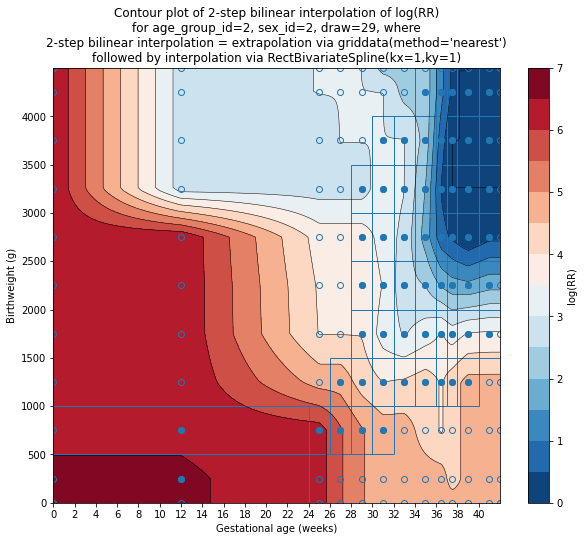

In [21]:
# Note: draw number was defined when we preprocessed rr data
age=2
sex=2
fig, ax = lbwsg_plots.single_log_rr_plot(
    gai,
    bwi,
    logrri_by_age_sex[(age, sex)],
    cat_df,
    logrri_xy_matches_axes=False,
    title="Contour plot of 2-step bilinear interpolation of log(RR)"
    f"\nfor age_group_id={age}, sex_id={sex}, {draw=}, where"
    "\n2-step bilinear interpolation = extrapolation via griddata(method='nearest')"
    "\nfollowed by interpolation via RectBivariateSpline(kx=1,ky=1)",
    draw_category_rectangles=True,
    draw_grid_midpoints=True,
    draw_grid_boundary_points=True,
);

In [22]:
fig.savefig(f"lbwsg_log_rr_countour_age_{age}_sex_{sex}_draw_{draw}.pdf")

In [23]:
max([logrri.max() for logrri in logrri_by_age_sex])

6.786177334765755

In [24]:
logrri_by_age_sex.map(np.max).max()

6.786177334765755

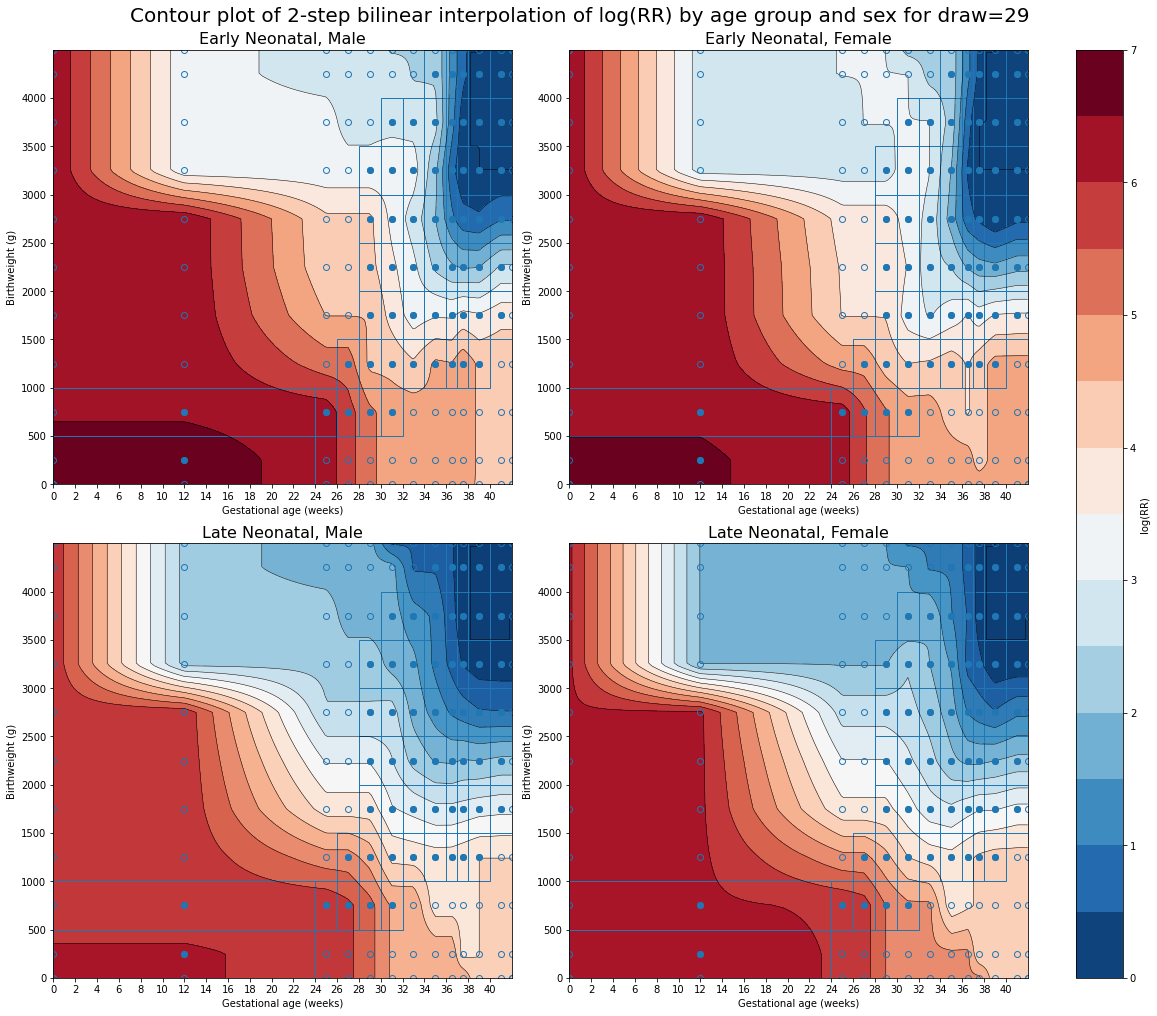

In [25]:
fig, axs, cntrs = lbwsg_plots.plot_log_rrs_by_age_sex(
    gai,
    bwi,
    logrri_by_age_sex,
    cat_df,
    logrri_xy_matches_axes=False,
    suptitle=f"Contour plot of 2-step bilinear interpolation of log(RR) by age group and sex for {draw=}",
    draw_category_rectangles=True,
    draw_grid_midpoints=True,
    draw_grid_boundary_points=True,
);

In [26]:
fig.savefig(f"lbwsg_log_rr_countour_by_age_and_sex_for_draw_{draw}.pdf")

# Recompute with mean RR's to plot log(mean(RR)) by age group and sex

In [27]:
%%time
rr_mean = get_rr_data(raw_rr, draw='mean', preprocess=True)
log_rr_mean_interpolator = make_lbwsg_log_rr_interpolator(rr_mean, cat_df)
rri_mean_by_age_sex = interpolate_lbwsg_rr_on_grid_by_age_sex(gai, bwi, log_rr_mean_interpolator, cat_df)
logrri_mean_by_age_sex = rri_mean_by_age_sex.map(np.log).rename("lbwsg_log_mean_relative_risk_on_grid")
logrri_mean_by_age_sex

Number of interpolation points in TMREL = 594

tmrel.shape=(200, 150)
CPU times: user 82.7 ms, sys: 9.8 ms, total: 92.5 ms
Wall time: 99.4 ms


age_group_id  sex_id
2             1         [[6.7773899681631065, 6.7773899681631065, 6.77...
              2         [[6.7534887685731055, 6.753488768573106, 6.753...
3             1         [[6.266798927077412, 6.266798927077412, 6.2667...
              2         [[6.355469230867395, 6.355469230867396, 6.3554...
Name: lbwsg_log_mean_relative_risk_on_grid, dtype: object

In [28]:
# Why are these greater than 594? Are there points outside the TMREL cats where mean(RR)=1?
# It could be points on the boundary since the intervals are half-open...
[(rri_mean==1).sum() for rri_mean in rri_mean_by_age_sex]

[633, 633, 633, 633]

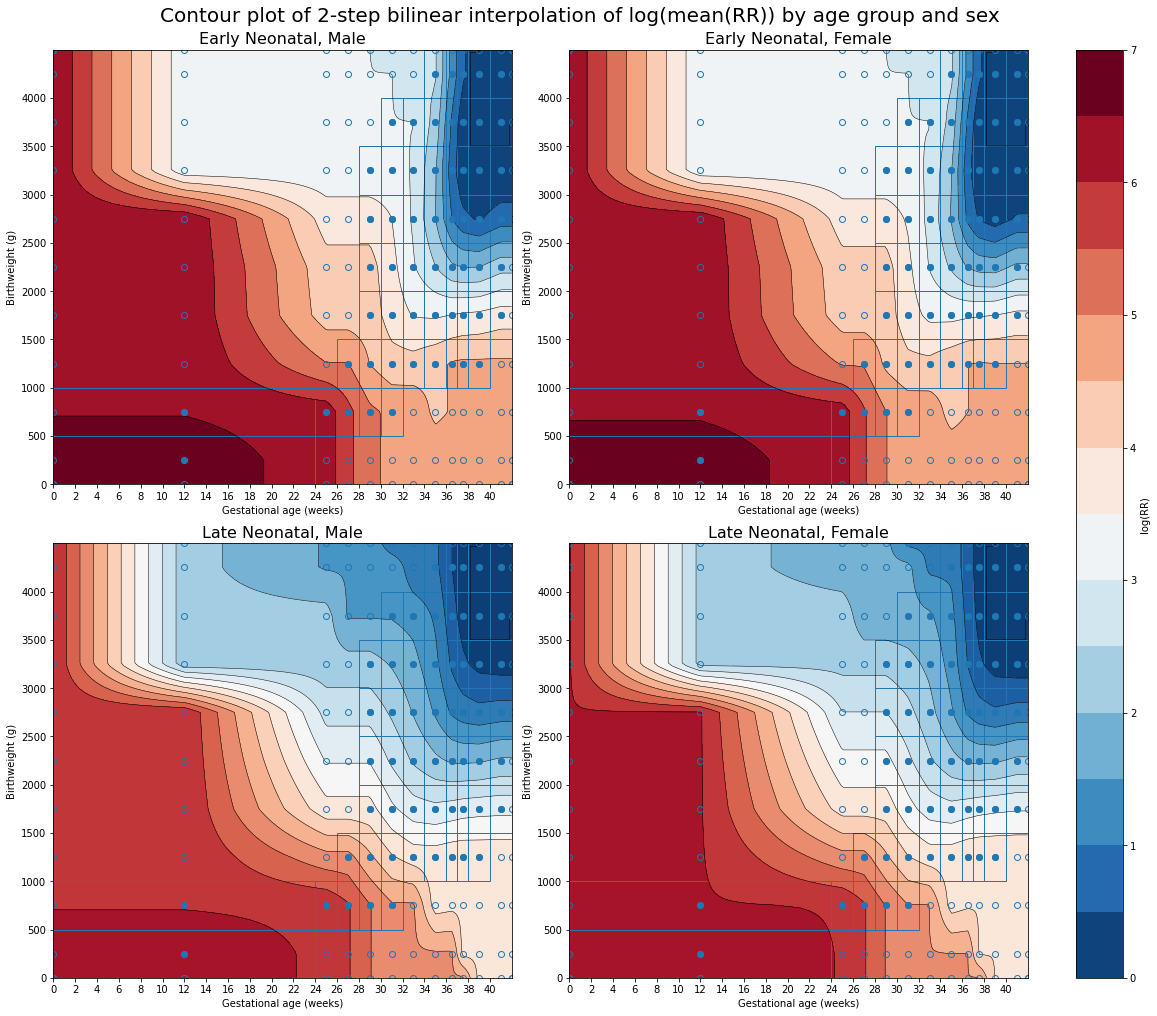

In [29]:
fig, axs, cntrs = lbwsg_plots.plot_log_rrs_by_age_sex(
    gai,
    bwi,
    logrri_mean_by_age_sex,
    cat_df,
    logrri_xy_matches_axes=False,
    suptitle="Contour plot of 2-step bilinear interpolation of log(mean(RR)) by age group and sex",
    draw_category_rectangles=True,
    draw_grid_midpoints=True,
    draw_grid_boundary_points=True,
);

In [30]:
fig.savefig(f"lbwsg_log_mean_rr_countour_by_age_and_sex.pdf")